<a href="https://colab.research.google.com/github/BhaskarKumarSinha/Ml-Deep-Learning-AI-Projects/blob/main/MLProjects/Building_a_Life_Saving_Heart_Disease_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [ ]:
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


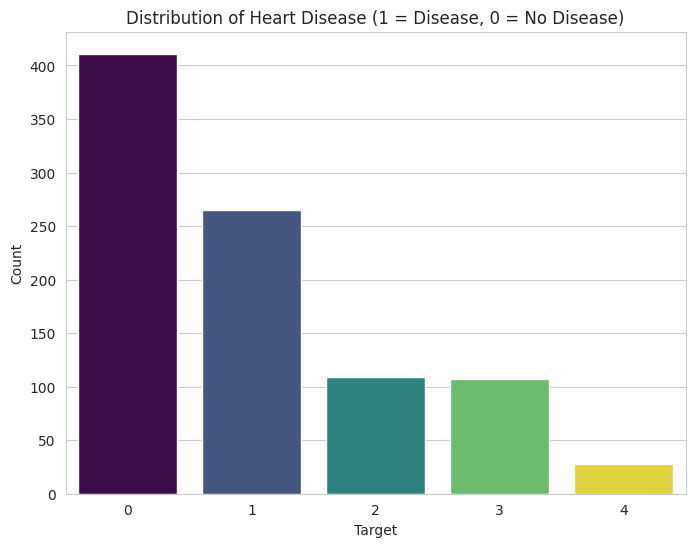

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

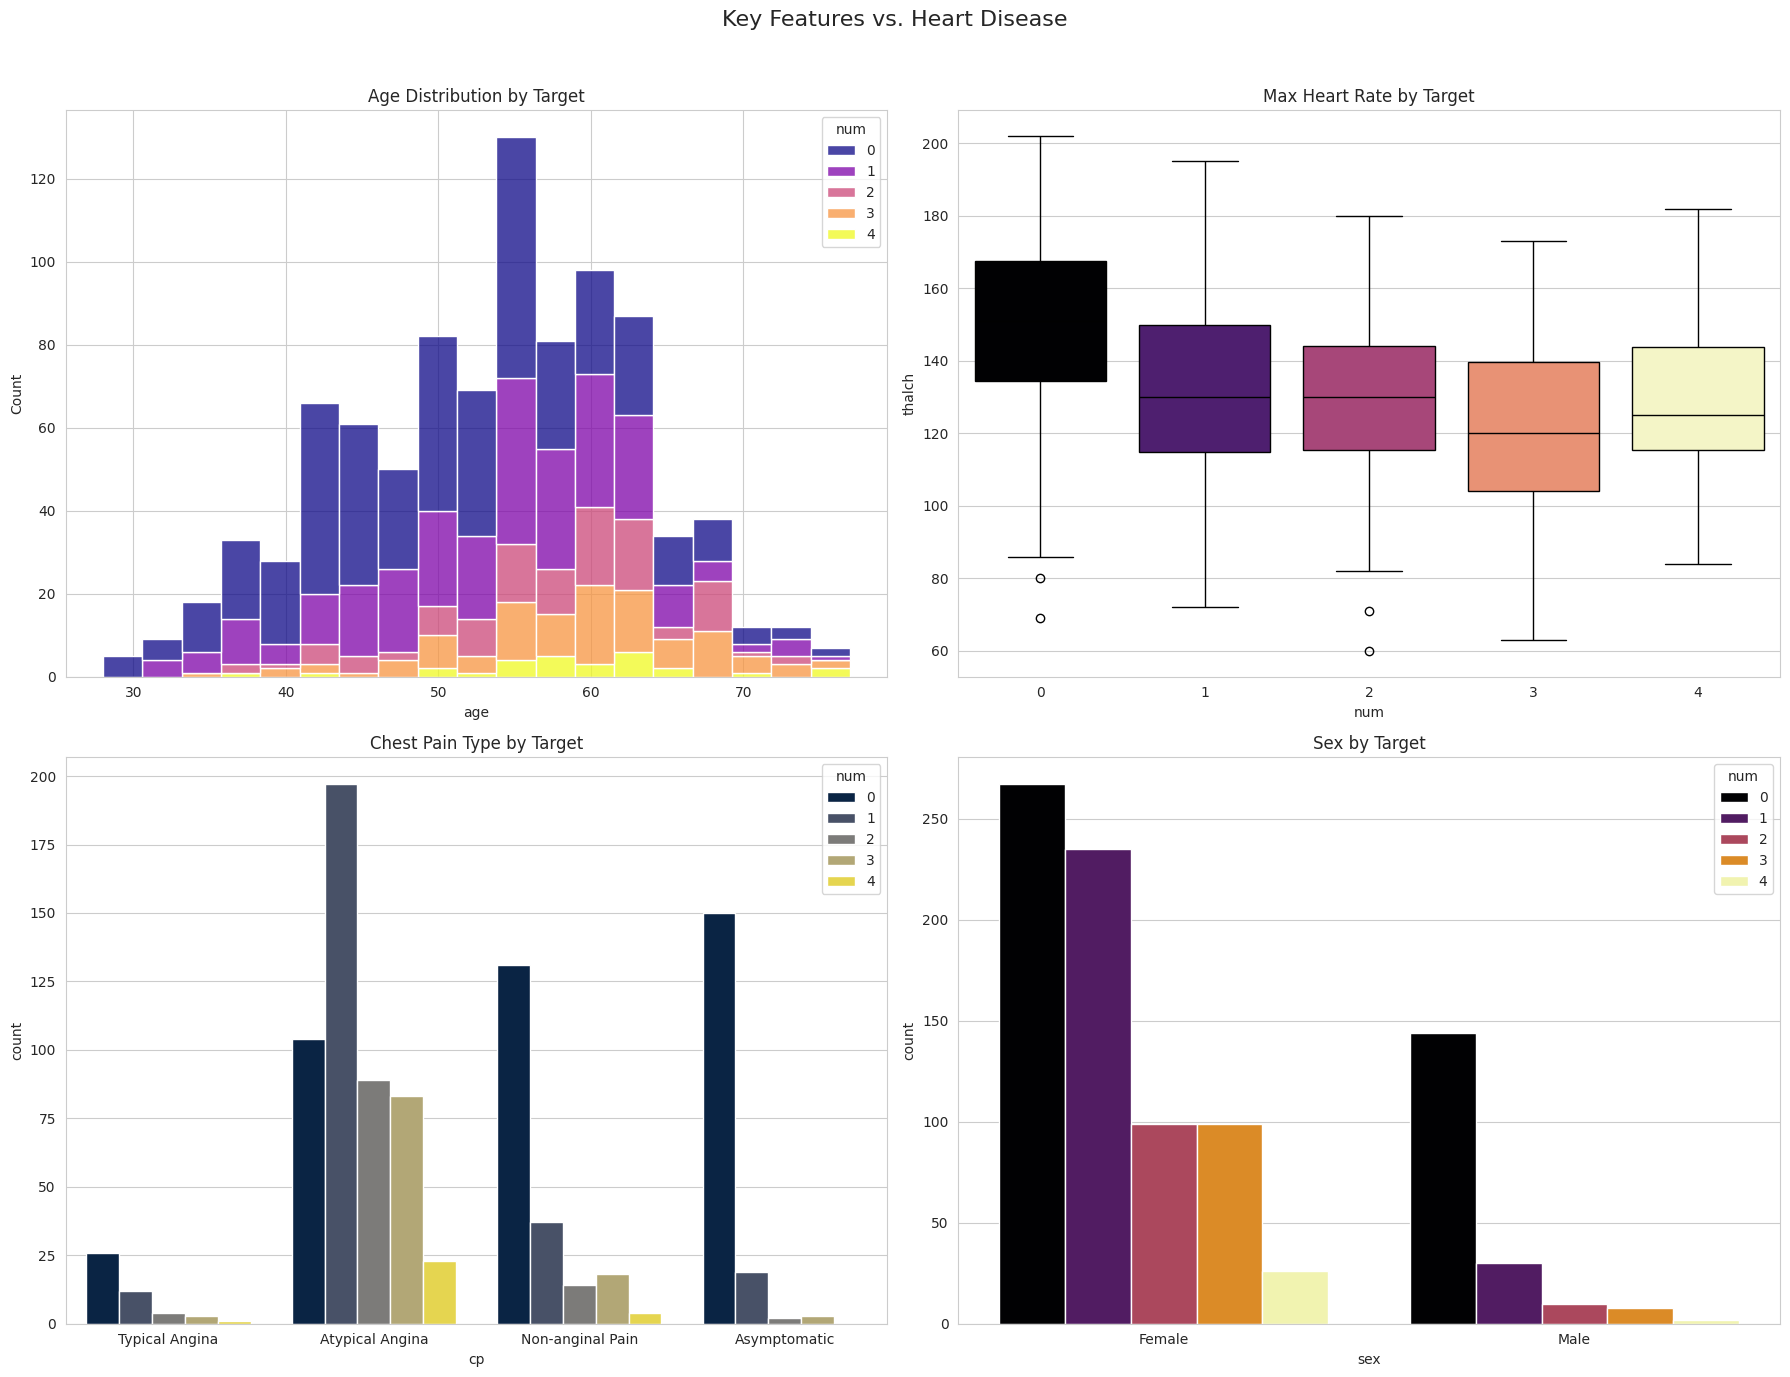

In [ ]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

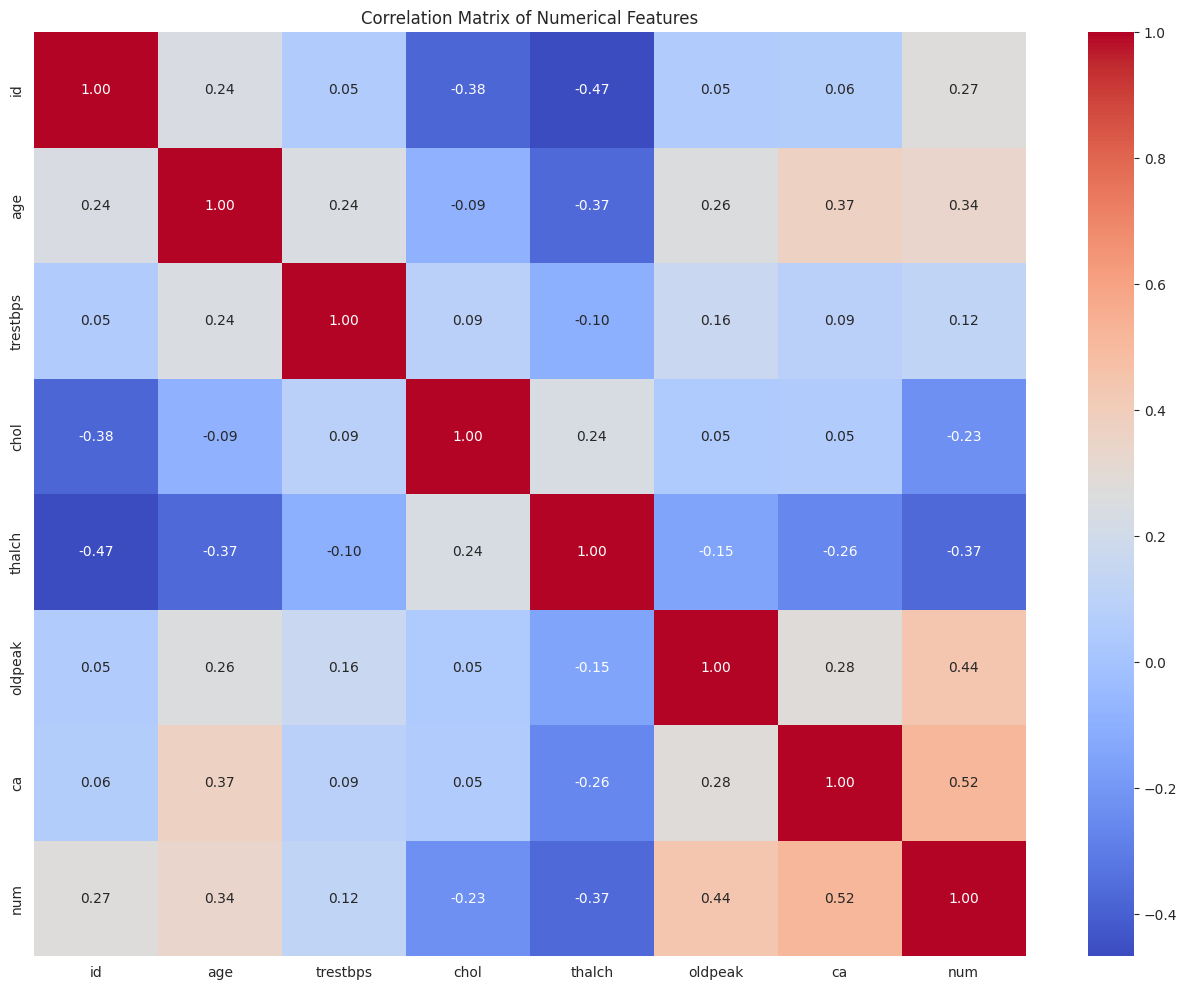

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)

In [ ]:
X.info()
X.isnull().sum()
y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  920 non-null    float64
 4   chol      920 non-null    float64
 5   fbs       920 non-null    bool   
 6   restecg   920 non-null    object 
 7   thalch    920 non-null    float64
 8   exang     920 non-null    bool   
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    object 
 11  ca        309 non-null    float64
 12  thal      920 non-null    object 
dtypes: bool(2), float64(5), int64(1), object(5)
memory usage: 81.0+ KB


,num
0,0
1,2
2,1
3,0
4,0
...,...
915,1
916,0
917,2
918,0


In [ ]:
all_features = X.columns.tolist()
categorical_features = [col for col in all_features if X[col].dtype == 'object']
numerical_features = [col for col in all_features if X[col].dtype != 'object']
numerical_features

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

In [ ]:
categorical_features

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [ ]:
X['trestbps'].value_counts()
X['trestbps'].mean()


np.float64(132.13240418118468)

In [ ]:
X.isnull().sum().sort_values(ascending=False)

,0
ca,611
thal,486
slope,309
fbs,90
oldpeak,62
trestbps,59
thalch,55
exang,55
chol,30
restecg,2


In [ ]:
X_trestbps_mean=X['trestbps'].mean()
X['trestbps']=X['trestbps'].fillna(X_trestbps_mean)

In [ ]:
X.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,30
fbs,90
restecg,2
thalch,55
exang,55
oldpeak,62


In [ ]:
# Find the mode of the 'chol' column
chol_mode = X['chol'].mode()[0]

# Fill missing values in 'chol' with the mode
X['chol'] = X['chol'].fillna(chol_mode)

# Verify that there are no more missing values in 'chol'
print("Missing values after filling with mode:")
print(X['chol'].isnull().sum())

Missing values after filling with mode:
0


In [ ]:
X['thalch'].value_counts()

,count
thalch,
150.0,43
140.0,41
120.0,35
130.0,30
160.0,26
...,...
63.0,1
67.0,1
107.0,1


In [ ]:
# Find the mean of the 'thalch' column
thalch_mean = X['thalch'].mean()

# Fill missing values in 'thalch' with the mean
X['thalch'] = X['thalch'].fillna(thalch_mean)

# Verify that there are no more missing values in 'thalch'
print("Missing values after filling with mean:")
print(X['thalch'].isnull().sum())

Missing values after filling with mean:
0


In [ ]:
X['oldpeak'].value_counts()
X['oldpeak'].mean()

np.float64(0.8787878787878788)

In [ ]:
# Find the mean of the 'oldpeak' column
oldpeak_mean = X['oldpeak'].mean()

# Fill missing values in 'oldpeak' with the mean
X['oldpeak'] = X['oldpeak'].fillna(oldpeak_mean)

# Verify that there are no more missing values in 'oldpeak'
print("Missing values after filling with mean:")
print(X['oldpeak'].isnull().sum())

Missing values after filling with mean:
0


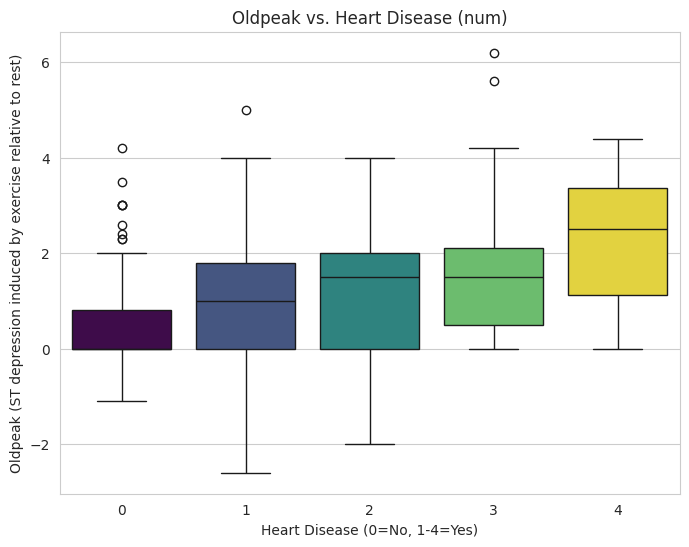

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='num', y='oldpeak', data=X.assign(num=y), palette='viridis', hue='num', legend=False)
plt.title('Oldpeak vs. Heart Disease (num)')
plt.xlabel('Heart Disease (0=No, 1-4=Yes)')
plt.ylabel('Oldpeak (ST depression induced by exercise relative to rest)')
plt.show()

In [ ]:
X.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,90
restecg,2
thalch,0
exang,55
oldpeak,0


In [ ]:
X[numerical_features].isnull().sum()

,0
age,0
trestbps,0
chol,0
thalch,0
oldpeak,0
ca,611


In [ ]:
# fill with mode for categorical
for column in categorical_features:
    X[column] = X[column].fillna(df[column].mode()[0])

/tmp/ipython-input-3948379878.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].fillna(df[column].mode()[0])


In [ ]:
X.isnull().sum()
#categorical_features

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,0


In [ ]:
# use knn imputer for large missing values
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

df_new = X.copy()


knn_cols = ['slope', 'ca', 'thal']

le_thal = LabelEncoder()
df_new['thal'] = le_thal.fit_transform(df_new['thal'].astype(str))

le_slope = LabelEncoder()
df_new['slope'] = le_slope.fit_transform(df_new['slope'].astype(str))

knn_imputer = KNNImputer(n_neighbors=5)
df_new[knn_cols] = knn_imputer.fit_transform(df_new[knn_cols])

print(pd.DataFrame(df_new.isnull().sum(), columns=['Missing Values']))

#for visualization
df_viz = df_new.copy()
df_viz['thal'] = le_thal.inverse_transform(df_new['thal'].astype(int))
df_viz['slope'] = le_slope.inverse_transform(df_new['slope'].astype(int))

          Missing Values
age                    0
sex                    0
cp                     0
trestbps               0
chol                   0
fbs                    0
restecg                0
thalch                 0
exang                  0
oldpeak                0
slope                  0
ca                     0
thal                   0


In [ ]:
# Identify categorical columns
cat_cols = df_new.select_dtypes(include=['object']).columns

# Apply Label Encoding
le = LabelEncoder()
for col in cat_cols:
    df_new[col] = le.fit_transform(df_new[col].astype(str))

In [ ]:
df_new

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,63,1,3,145.000000,233.0,True,0,150.000000,False,2.300000,0.0,0.0,0.0
1,67,1,0,160.000000,286.0,False,0,108.000000,True,1.500000,1.0,3.0,1.0
2,67,1,0,120.000000,229.0,False,0,129.000000,True,2.600000,1.0,2.0,2.0
3,37,1,2,130.000000,250.0,False,1,187.000000,False,3.500000,0.0,0.0,1.0
4,41,0,1,130.000000,204.0,False,0,172.000000,False,1.400000,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0,0,127.000000,333.0,True,2,154.000000,False,0.000000,1.0,0.6,1.0
916,62,1,3,132.132404,139.0,False,2,137.545665,False,0.878788,1.0,0.6,1.0
917,55,1,0,122.000000,223.0,True,2,100.000000,False,0.000000,1.0,0.8,0.0
918,58,1,0,132.132404,385.0,True,0,137.545665,False,0.878788,1.0,0.6,1.0


In [ ]:
y.value_counts()

,count
num,
0,411
1,265
2,109
3,107
4,28


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,63,Male,typical angina,145.000000,233.0,True,lv hypertrophy,150.000000,False,2.300000,downsloping,0.0,fixed defect
1,67,Male,asymptomatic,160.000000,286.0,False,lv hypertrophy,108.000000,True,1.500000,flat,3.0,normal
2,67,Male,asymptomatic,120.000000,229.0,False,lv hypertrophy,129.000000,True,2.600000,flat,2.0,reversable defect
3,37,Male,non-anginal,130.000000,250.0,False,normal,187.000000,False,3.500000,downsloping,0.0,normal
4,41,Female,atypical angina,130.000000,204.0,False,lv hypertrophy,172.000000,False,1.400000,upsloping,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,asymptomatic,127.000000,333.0,True,st-t abnormality,154.000000,False,0.000000,flat,NaN,normal
916,62,Male,typical angina,132.132404,139.0,False,st-t abnormality,137.545665,False,0.878788,flat,NaN,normal
917,55,Male,asymptomatic,122.000000,223.0,True,st-t abnormality,100.000000,False,0.000000,flat,NaN,fixed defect
918,58,Male,asymptomatic,132.132404,385.0,True,lv hypertrophy,137.545665,False,0.878788,flat,NaN,normal


In [ ]:
df_new.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,0


In [ ]:
y

,num
0,0
1,2
2,1
3,0
4,0
...,...
915,1
916,0
917,2
918,0


##Model training and report for several model such as logisitic regression,random forest,svm,knn

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new, y, stratify=y,
                                                    test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
log_cl = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_cl.fit(X_train, y_train)
# Train report
y_train_pred = log_cl.predict(X_train)
print("Train Report:")
print(classification_report(y_train, y_train_pred))

# Test report
y_test_pred = log_cl.predict(X_test)
print("Test Report:")
print(classification_report(y_test, y_test_pred))

Train Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       329
           1       0.51      0.38      0.44       212
           2       0.24      0.25      0.24        87
           3       0.41      0.45      0.43        86
           4       0.16      0.55      0.25        22

    accuracy                           0.55       736
   macro avg       0.42      0.48      0.43       736
weighted avg       0.58      0.55      0.56       736

Test Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.38      0.30      0.34        53
           2       0.14      0.09      0.11        22
           3       0.10      0.14      0.12        21
           4       0.17      0.67      0.28         6

    accuracy                           0.48       184
   macro avg       0.33      0.40      0.33       184
weighted avg       0.52      0.48      0.50       

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("Random Forest - Train Report:")
print(classification_report(y_train, y_train_pred_rf))
print("\nRandom Forest - Test Report:")
print(classification_report(y_test, y_test_pred_rf))

Random Forest - Train Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       212
           2       1.00      1.00      1.00        87
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        22

    accuracy                           1.00       736
   macro avg       1.00      1.00      1.00       736
weighted avg       1.00      1.00      1.00       736


Random Forest - Test Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        82
           1       0.52      0.57      0.54        53
           2       0.12      0.09      0.11        22
           3       0.18      0.19      0.19        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.32      0.33      0.32       184
weighted avg     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Support Vector Machine (SVM) Classifier

In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM model
# Using a linear kernel for simplicity, you can experiment with others
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

# Make predictions
y_train_pred_svm = svm_clf.predict(X_train)
y_test_pred_svm = svm_clf.predict(X_test)

# Evaluate the model
print("SVM - Train Report:")
print(classification_report(y_train, y_train_pred_svm))
print("\nSVM - Test Report:")
print(classification_report(y_test, y_test_pred_svm))

SVM - Train Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       329
           1       0.48      0.58      0.52       212
           2       0.00      0.00      0.00        87
           3       0.46      0.44      0.45        86
           4       0.00      0.00      0.00        22

    accuracy                           0.61       736
   macro avg       0.33      0.38      0.35       736
weighted avg       0.51      0.61      0.56       736


SVM - Test Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        82
           1       0.50      0.60      0.55        53
           2       0.00      0.00      0.00        22
           3       0.09      0.10      0.09        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.27      0.32      0.29       184
weighted avg       0.49      0.58    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

### K-Nearest Neighbors (KNN) Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN model
# Using n_neighbors=5 as a starting point, you can tune this parameter
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Make predictions
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

# Evaluate the model
print("KNN - Train Report:")
print(classification_report(y_train, y_train_pred_knn))
print("\nKNN - Test Report:")
print(classification_report(y_test, y_test_pred_knn))

KNN - Train Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       329
           1       0.58      0.65      0.61       212
           2       0.46      0.31      0.37        87
           3       0.68      0.35      0.46        86
           4       0.67      0.09      0.16        22

    accuracy                           0.66       736
   macro avg       0.62      0.45      0.48       736
weighted avg       0.65      0.66      0.64       736


KNN - Test Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        82
           1       0.46      0.57      0.51        53
           2       0.36      0.18      0.24        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.32      0.33      0.31       184
weighted avg       0.51      0.58    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Now we convert datasets into binary classification For the target variable, all classes except 0 were converted to 1. This simplifies the problem into a binary classification task: 0 = no heart disease, 1 = presence of heart disease.

In [ ]:
y_new=(y!=0).astype(int)

In [ ]:
y_new.value_counts()

,count
num,
1,509
0,411


##Model Training for Logistic regression

In [ ]:
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new, y_new, stratify=y,
                                                    test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

In [ ]:
log_cl = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_cl.fit(X_train_new, y_train_new)
# Train report
y_train_pred_new = log_cl.predict(X_train_new)
print("Train Report:")
print(classification_report(y_train_new, y_train_pred_new))

# Test report
y_test_pred_new = log_cl.predict(X_test_new)
print("Test Report:")
print(classification_report(y_test_new, y_test_pred_new))

Train Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       329
           1       0.83      0.78      0.80       407

    accuracy                           0.79       736
   macro avg       0.79      0.79      0.79       736
weighted avg       0.79      0.79      0.79       736

Test Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        82
           1       0.85      0.86      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



### Random Forest Classifier with Binary Target

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model with binary target
rf_clf_new = RandomForestClassifier(random_state=42)
rf_clf_new.fit(X_train_new, y_train_new)

# Make predictions
y_train_pred_rf_new = rf_clf_new.predict(X_train_new)
y_test_pred_rf_new = rf_clf_new.predict(X_test_new)

# Evaluate the model
print("Random Forest (Binary) - Train Report:")
print(classification_report(y_train_new, y_train_pred_rf_new))
print("\nRandom Forest (Binary) - Test Report:")
print(classification_report(y_test_new, y_test_pred_rf_new))

Random Forest (Binary) - Train Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       407

    accuracy                           1.00       736
   macro avg       1.00      1.00      1.00       736
weighted avg       1.00      1.00      1.00       736


Random Forest (Binary) - Test Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        82
           1       0.82      0.91      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



### Support Vector Machine (SVM) Classifier with Binary Target

In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM model with binary target
svm_clf_new = SVC(kernel='linear', random_state=42)
svm_clf_new.fit(X_train_new, y_train_new)

# Make predictions
y_train_pred_svm_new = svm_clf_new.predict(X_train_new)
y_test_pred_svm_new = svm_clf_new.predict(X_test_new)

# Evaluate the model
print("SVM (Binary) - Train Report:")
print(classification_report(y_train_new, y_train_pred_svm_new))
print("\nSVM (Binary) - Test Report:")
print(classification_report(y_test_new, y_test_pred_svm_new))

SVM (Binary) - Train Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       329
           1       0.82      0.80      0.81       407

    accuracy                           0.79       736
   macro avg       0.79      0.79      0.79       736
weighted avg       0.79      0.79      0.79       736


SVM (Binary) - Test Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        82
           1       0.84      0.86      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



### K-Nearest Neighbors (KNN) Classifier with Binary Target

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN model with binary target
# Using n_neighbors=5 as a starting point
knn_clf_new = KNeighborsClassifier(n_neighbors=5)
knn_clf_new.fit(X_train_new, y_train_new)

# Make predictions
y_train_pred_knn_new = knn_clf_new.predict(X_train_new)
y_test_pred_knn_new = knn_clf_new.predict(X_test_new)

# Evaluate the model
print("KNN (Binary) - Train Report:")
print(classification_report(y_train_new, y_train_pred_knn_new))
print("\nKNN (Binary) - Test Report:")
print(classification_report(y_test_new, y_test_pred_knn_new))

KNN (Binary) - Train Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       329
           1       0.86      0.86      0.86       407

    accuracy                           0.84       736
   macro avg       0.84      0.84      0.84       736
weighted avg       0.84      0.84      0.84       736


KNN (Binary) - Test Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        82
           1       0.86      0.82      0.84       102

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.83      0.83       184



## Model Performance Summary

Based on the training and evaluation of the Logistic Regression, Random Forest, SVM, and KNN models, here's a summary of their performance:

**Multi-class Classification (Predicting Heart Disease Severity 0-4)**

*   **Logistic Regression:** Test Accuracy = 0.48
*   **Random Forest:** Test Accuracy = 0.56 (Showed significant overfitting on the training data)
*   **SVM:** Test Accuracy = 0.58
*   **KNN:** Test Accuracy = 0.58

**Binary Classification (Predicting Presence of Heart Disease 0 vs 1)**

*   **Logistic Regression:** Test Accuracy = 0.84
*   **Random Forest:** Test Accuracy = 0.84
*   **SVM:** Test Accuracy = 0.83
*   **KNN:** Test Accuracy = 0.83

**Key Insights:**

*   Converting the problem to a binary classification task (presence vs. absence of heart disease) significantly improved model performance compared to the multi-class classification of severity levels.
*   All four models achieved similar and relatively high accuracy scores (around 83-84%) in the binary classification setting.
*   The models struggled with predicting the minority classes (severity levels 2, 3, and 4) in the multi-class setting, likely due to class imbalance.
*   Random Forest showed signs of overfitting in the multi-class scenario.

Overall, the models are more effective at predicting whether a patient has heart disease or not, rather than the specific severity level. To improve multi-class performance, addressing class imbalance and potentially using more advanced techniques would be necessary.